ZOMATO DELIVERY PREDICTION - PHASE 3: MODEL TRAINING & DEPLOYMENT PREP
STEP 1: DATA PREPARATION FOR MODELING
Loading final dataset...
Dataset shape: (11, 31)
Features: 30
Samples: 11

Target variable: Time_taken (min)
Target statistics - Mean: 30.55, Std: 10.93
Features shape: (11, 30)

Train set: 8 samples
Test set: 3 samples

Scaling features...

STEP 2: MODEL TRAINING & COMPARISON
Training and evaluating models...
--------------------------------------------------------------------------------

Training Linear Regression...
  Training Time: 0.21 seconds
  Train MAE: 0.0000, Test MAE: 18.5695
  Train RMSE: 0.0000, Test RMSE: 28.4988
  Train R²: 1.0000, Test R²: -3.3981
  ⚠️  Potential overfitting (MAE diff: -18.57)

Training Ridge Regression...
  Training Time: 0.22 seconds
  Train MAE: 0.6639, Test MAE: 12.7886
  Train RMSE: 0.7830, Test RMSE: 19.8586
  Train R²: 0.9917, Test R²: -1.1355
  ⚠️  Potential overfitting (MAE diff: -12.12)

Training Lasso Regression...
  Training Time: 0.

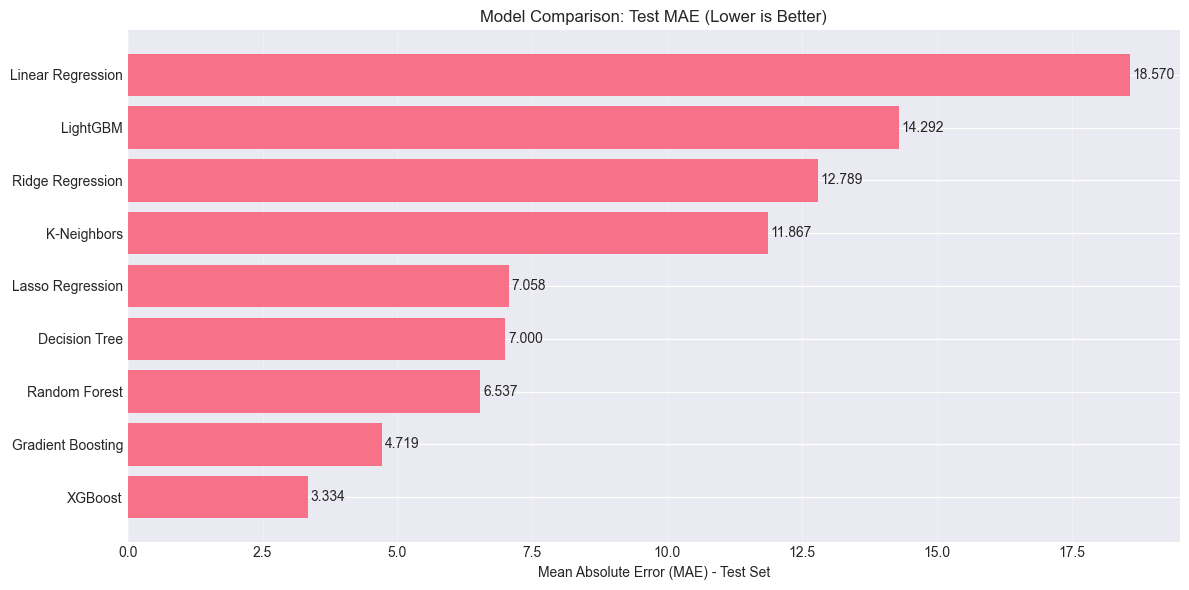

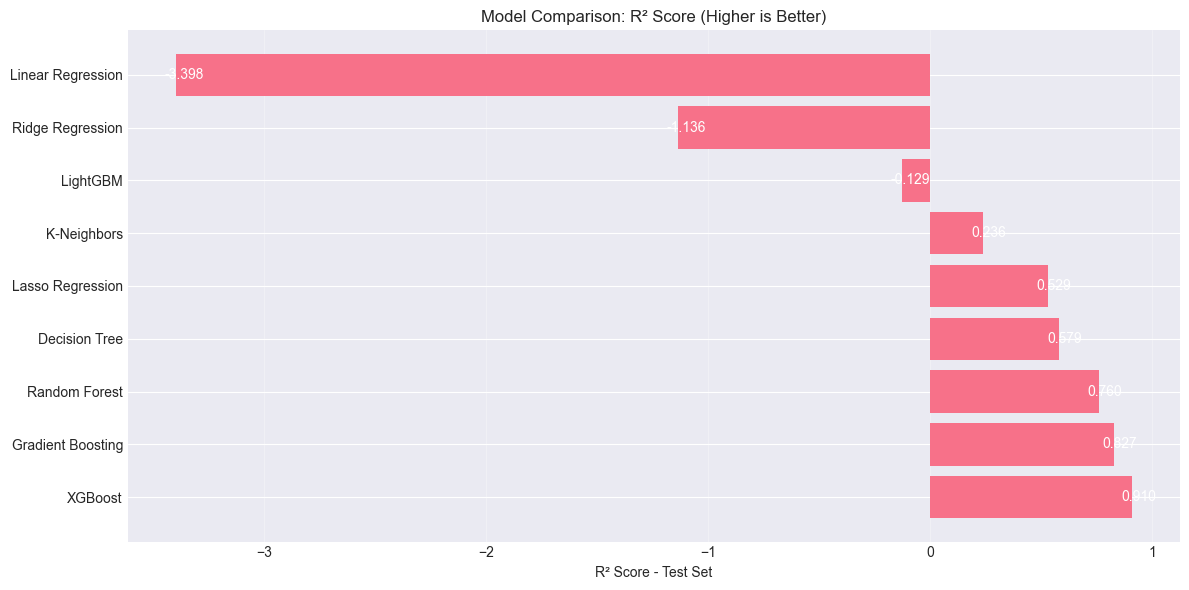

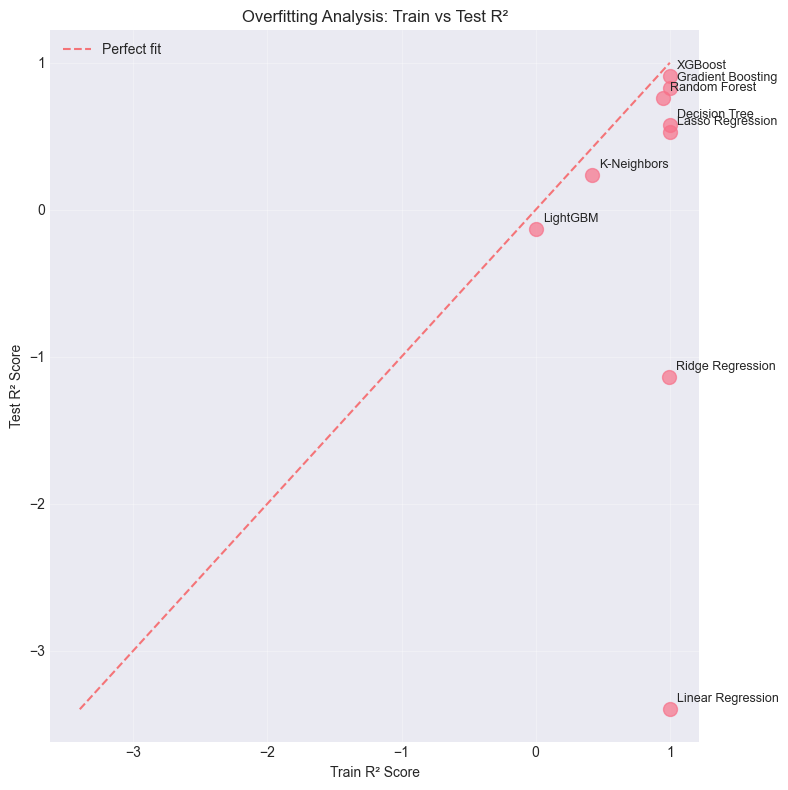

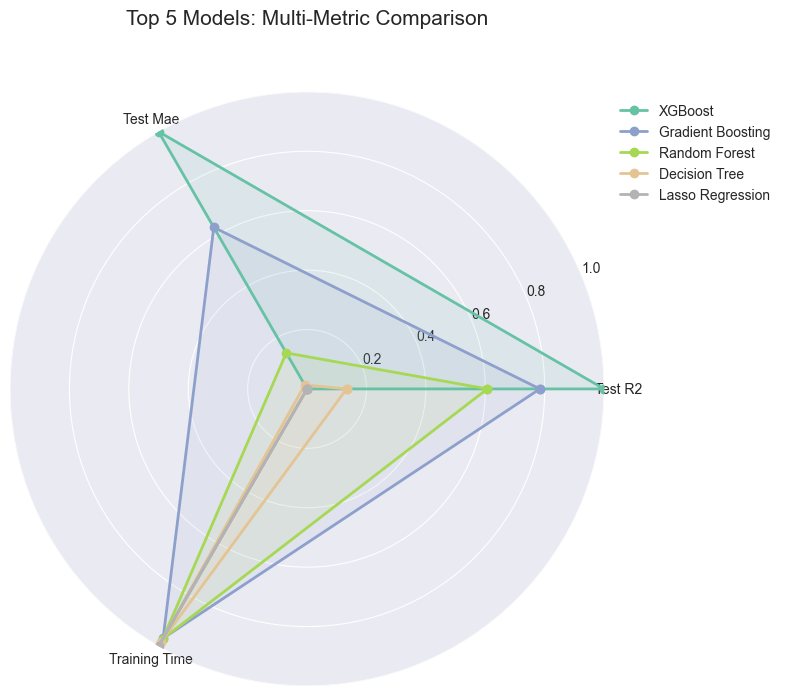


Model Performance Summary:
------------------------------------------------------------------------------------------------------------------------
Model                     Test MAE   Test RMSE  Test R²    Train R²   Time (s)  
------------------------------------------------------------------------------------------------------------------------
XGBoost                   3.3345     4.0833     0.9097     1.0000     2.49      
Gradient Boosting         4.7193     5.6479     0.8273     1.0000     0.12      
Random Forest             6.5367     6.6583     0.7599     0.9490     0.12      
Decision Tree             7.0000     8.8129     0.5794     1.0000     0.09      
Lasso Regression          7.0580     9.3292     0.5287     0.9996     0.05      
K-Neighbors               11.8667    11.8783    0.2360     0.4182     0.28      
Ridge Regression          12.7886    19.8586    -1.1355    0.9917     0.22      
LightGBM                  14.2917    14.4372    -0.1287    0.0000     4.80      
L

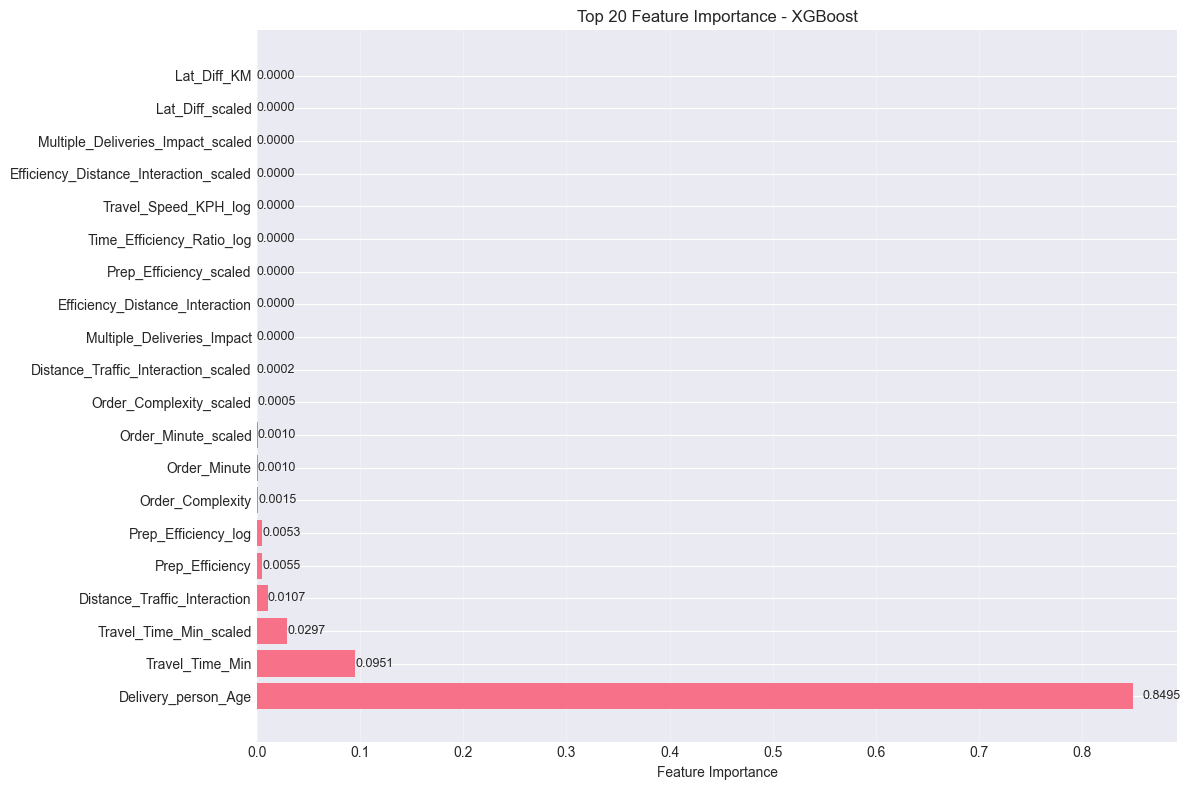


Top 20 Most Important Features:
------------------------------------------------------------
30. Delivery_person_Age                 : 0.849471
 1. Travel_Time_Min                     : 0.095112
 2. Travel_Time_Min_scaled              : 0.029711
 8. Distance_Traffic_Interaction        : 0.010709
 4. Prep_Efficiency                     : 0.005529
 3. Prep_Efficiency_log                 : 0.005322
 7. Order_Complexity                    : 0.001459
16. Order_Minute                        : 0.001009
17. Order_Minute_scaled                 : 0.000998
 6. Order_Complexity_scaled             : 0.000497
 9. Distance_Traffic_Interaction_scaled : 0.000174
14. Multiple_Deliveries_Impact          : 0.000009
10. Efficiency_Distance_Interaction     : 0.000000
 5. Prep_Efficiency_scaled              : 0.000000
13. Time_Efficiency_Ratio_log           : 0.000000
12. Travel_Speed_KPH_log                : 0.000000
11. Efficiency_Distance_Interaction_scaled : 0.000000
15. Multiple_Deliveries_Impact_scale

In [1]:
# ============================================================================
# ZOMATO DELIVERY TIME PREDICTION - PHASE 3: MODEL TRAINING & COMPARISON
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import time
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# STEP 1: DATA PREPARATION FOR MODELING
# ============================================================================

def prepare_modeling_data(file_path='zomato_delivery_modeling_ready.csv'):
    """
    Load and prepare the final dataset for modeling
    """
    print("="*80)
    print("STEP 1: DATA PREPARATION FOR MODELING")
    print("="*80)
    
    # Load the final dataset from Phase 2
    print("Loading final dataset...")
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Features: {len(df.columns) - 1}")
    print(f"Samples: {len(df)}")
    
    # Separate features and target
    target_col = 'Time_taken (min)'
    
    if target_col not in df.columns:
        # Try to find target column with different name
        possible_targets = [col for col in df.columns if 'time' in col.lower() or 'taken' in col.lower()]
        if possible_targets:
            target_col = possible_targets[0]
        else:
            raise ValueError("Target column not found. Please check column names.")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"\nTarget variable: {target_col}")
    print(f"Target statistics - Mean: {y.mean():.2f}, Std: {y.std():.2f}")
    print(f"Features shape: {X.shape}")
    
    # Split into train and test sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Feature scaling (optional, depending on models)
    print("\nScaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame with column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    
    return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler

# ============================================================================
# STEP 2: MODEL TRAINING & COMPARISON
# ============================================================================

def train_and_compare_models(X_train, X_test, y_train, y_test, X_train_scaled=None, X_test_scaled=None):
    """
    Train multiple models and compare their performance
    """
    print("\n" + "="*80)
    print("STEP 2: MODEL TRAINING & COMPARISON")
    print("="*80)
    
    # Dictionary to store model results
    model_results = {}
    trained_models = {}
    
    # Define models to compare
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'Lasso Regression': Lasso(alpha=0.01, random_state=42),
        'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
        'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
        'K-Neighbors': KNeighborsRegressor(n_neighbors=5)
    }
    
    print("Training and evaluating models...")
    print("-" * 80)
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()
        
        # Determine which dataset to use (scaled or unscaled)
        if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'K-Neighbors']:
            # Use scaled data for models sensitive to feature scale
            X_tr = X_train_scaled if X_train_scaled is not None else X_train
            X_te = X_test_scaled if X_test_scaled is not None else X_test
        else:
            # Tree-based models don't require scaling
            X_tr = X_train
            X_te = X_test
        
        # Train the model
        model.fit(X_tr, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)
        
        # Calculate metrics
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Calculate training time
        training_time = time.time() - start_time
        
        # Store results
        model_results[model_name] = {
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time
        }
        
        # Store trained model
        trained_models[model_name] = model
        
        # Print results
        print(f"  Training Time: {training_time:.2f} seconds")
        print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
        
        # Check for overfitting
        overfit_mae = train_mae - test_mae
        if overfit_mae < -2:  # Train MAE much lower than test MAE
            print(f"  ⚠️  Potential overfitting (MAE diff: {overfit_mae:.2f})")
    
    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(model_results).T
    
    return results_df, trained_models

# ============================================================================
# STEP 3: VISUALIZE MODEL COMPARISON
# ============================================================================

def visualize_model_comparison(results_df):
    """
    Create visualizations to compare model performance
    """
    print("\n" + "="*80)
    print("STEP 3: VISUALIZING MODEL COMPARISON")
    print("="*80)
    
    # Create directory for saving plots
    import os
    os.makedirs('model_results', exist_ok=True)
    
    # 1. Bar chart comparing Test MAE
    plt.figure(figsize=(12, 6))
    
    # Sort models by test MAE (ascending)
    sorted_results = results_df.sort_values('test_mae')
    
    bars = plt.barh(range(len(sorted_results)), sorted_results['test_mae'])
    plt.yticks(range(len(sorted_results)), sorted_results.index)
    plt.xlabel('Mean Absolute Error (MAE) - Test Set')
    plt.title('Model Comparison: Test MAE (Lower is Better)')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add MAE values on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                f'{sorted_results.iloc[i]["test_mae"]:.3f}', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('model_results/model_comparison_mae.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # 2. Bar chart comparing Test R²
    plt.figure(figsize=(12, 6))
    
    # Sort models by test R² (descending)
    sorted_results_r2 = results_df.sort_values('test_r2', ascending=False)
    
    bars = plt.barh(range(len(sorted_results_r2)), sorted_results_r2['test_r2'])
    plt.yticks(range(len(sorted_results_r2)), sorted_results_r2.index)
    plt.xlabel('R² Score - Test Set')
    plt.title('Model Comparison: R² Score (Higher is Better)')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add R² values on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height()/2,
                f'{sorted_results_r2.iloc[i]["test_r2"]:.3f}', 
                va='center', fontsize=10, color='white')
    
    plt.tight_layout()
    plt.savefig('model_results/model_comparison_r2.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # 3. Scatter plot of Train vs Test R²
    plt.figure(figsize=(8, 8))
    
    plt.scatter(results_df['train_r2'], results_df['test_r2'], s=100, alpha=0.7)
    
    # Add model labels
    for model_name in results_df.index:
        plt.annotate(model_name, 
                    (results_df.loc[model_name, 'train_r2'], 
                     results_df.loc[model_name, 'test_r2']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add diagonal line (perfect fit between train and test)
    min_val = min(results_df['train_r2'].min(), results_df['test_r2'].min())
    max_val = max(results_df['train_r2'].max(), results_df['test_r2'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect fit')
    
    plt.xlabel('Train R² Score')
    plt.ylabel('Test R² Score')
    plt.title('Overfitting Analysis: Train vs Test R²')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_results/overfitting_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # 4. Radar chart for multi-metric comparison (for top 5 models)
    top_models = results_df.sort_values('test_r2', ascending=False).head(5)
    
    # Normalize metrics for radar chart (0 to 1, where 1 is best)
    radar_metrics = ['test_r2', 'test_mae', 'training_time']
    
    # For MAE and training time, lower is better, so invert
    radar_data = pd.DataFrame()
    for metric in radar_metrics:
        if metric in ['test_mae', 'training_time']:
            # Invert so higher is better
            max_val = top_models[metric].max()
            min_val = top_models[metric].min()
            if max_val != min_val:
                radar_data[metric] = 1 - (top_models[metric] - min_val) / (max_val - min_val)
            else:
                radar_data[metric] = 0.5
        else:
            # For R², higher is already better
            max_val = top_models[metric].max()
            min_val = top_models[metric].min()
            if max_val != min_val:
                radar_data[metric] = (top_models[metric] - min_val) / (max_val - min_val)
            else:
                radar_data[metric] = 0.5
    
    radar_data.index = top_models.index
    
    # Create radar chart
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(radar_data)))
    
    for idx, (model_name, row) in enumerate(radar_data.iterrows()):
        values = row.tolist()
        values += values[:1]  # Close the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
        ax.fill(angles, values, alpha=0.1, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').title() for m in radar_metrics])
    ax.set_ylim(0, 1)
    ax.set_title('Top 5 Models: Multi-Metric Comparison', size=15, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    plt.savefig('model_results/radar_comparison.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # 5. Print summary table
    print("\nModel Performance Summary:")
    print("-" * 120)
    print(f"{'Model':<25} {'Test MAE':<10} {'Test RMSE':<10} {'Test R²':<10} {'Train R²':<10} {'Time (s)':<10}")
    print("-" * 120)
    
    for model_name in results_df.sort_values('test_mae').index:
        row = results_df.loc[model_name]
        print(f"{model_name:<25} {row['test_mae']:<10.4f} {row['test_rmse']:<10.4f} "
              f"{row['test_r2']:<10.4f} {row['train_r2']:<10.4f} {row['training_time']:<10.2f}")
    
    print("-" * 120)
    
    # Save results to CSV
    results_df.to_csv('model_results/model_comparison_results.csv')
    print(f"\nDetailed results saved to: model_results/model_comparison_results.csv")
    
    return results_df

# ============================================================================
# STEP 4: HYPERPARAMETER TUNING FOR BEST MODEL
# ============================================================================

def hyperparameter_tuning(X_train, y_train, X_test, y_test, best_model_name, trained_models):
    """
    Perform hyperparameter tuning for the best performing model
    """
    print("\n" + "="*80)
    print(f"STEP 4: HYPERPARAMETER TUNING FOR {best_model_name}")
    print("="*80)
    
    # Get the best model
    if best_model_name not in trained_models:
        print(f"Model {best_model_name} not found in trained models.")
        return None, None
    
    base_model = trained_models[best_model_name]
    
    # Define hyperparameter grids for different models
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'LightGBM': {
            'n_estimators': [50, 100, 200],
            'num_leaves': [31, 50, 100],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [5, 10, 15],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Ridge Regression': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        }
    }
    
    # Get the appropriate parameter grid
    param_grid = param_grids.get(best_model_name)
    
    if param_grid is None:
        print(f"No hyperparameter grid defined for {best_model_name}")
        print("Using default model.")
        return base_model, None
    
    print(f"Performing RandomizedSearchCV for {best_model_name}...")
    print(f"Parameter grid: {param_grid}")
    
    # Create model instance
    if best_model_name == 'Random Forest':
        model = RandomForestRegressor(random_state=42)
    elif best_model_name == 'XGBoost':
        model = XGBRegressor(random_state=42, verbosity=0)
    elif best_model_name == 'LightGBM':
        model = LGBMRegressor(random_state=42, verbose=-1)
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingRegressor(random_state=42)
    elif best_model_name == 'Ridge Regression':
        model = Ridge(random_state=42)
    else:
        print(f"Hyperparameter tuning not implemented for {best_model_name}")
        return base_model, None
    
    # Perform randomized search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings to sample
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',  # We want to minimize MAE
        n_jobs=-1,  # Use all available cores
        random_state=42,
        verbose=1
    )
    
    # Fit the random search
    start_time = time.time()
    random_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"\nHyperparameter tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score (negative MAE): {random_search.best_score_:.4f}")
    
    # Evaluate the tuned model
    tuned_model = random_search.best_estimator_
    
    # Make predictions
    y_pred_train_tuned = tuned_model.predict(X_train)
    y_pred_test_tuned = tuned_model.predict(X_test)
    
    # Calculate metrics
    train_mae_tuned = mean_absolute_error(y_train, y_pred_train_tuned)
    test_mae_tuned = mean_absolute_error(y_test, y_pred_test_tuned)
    
    train_r2_tuned = r2_score(y_train, y_pred_train_tuned)
    test_r2_tuned = r2_score(y_test, y_pred_test_tuned)
    
    print(f"\nTuned Model Performance:")
    print(f"  Train MAE: {train_mae_tuned:.4f} (Before: {mean_absolute_error(y_train, base_model.predict(X_train)):.4f})")
    print(f"  Test MAE: {test_mae_tuned:.4f} (Before: {mean_absolute_error(y_test, base_model.predict(X_test)):.4f})")
    print(f"  Train R²: {train_r2_tuned:.4f} (Before: {r2_score(y_train, base_model.predict(X_train)):.4f})")
    print(f"  Test R²: {test_r2_tuned:.4f} (Before: {r2_score(y_test, base_model.predict(X_test)):.4f})")
    
    # Improvement calculation
    base_test_mae = mean_absolute_error(y_test, base_model.predict(X_test))
    improvement = ((base_test_mae - test_mae_tuned) / base_test_mae) * 100
    
    if improvement > 0:
        print(f"\nImprovement: {improvement:.2f}% reduction in test MAE")
    else:
        print(f"\nNo improvement. Default parameters were better.")
    
    return tuned_model, random_search.best_params_

# ============================================================================
# STEP 5: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

def analyze_feature_importance(tuned_model, X_train, best_model_name, top_n=20):
    """
    Analyze and visualize feature importance
    """
    print("\n" + "="*80)
    print("STEP 5: FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    feature_names = X_train.columns.tolist()
    
    # Get feature importance based on model type
    if hasattr(tuned_model, 'feature_importances_'):
        # Tree-based models
        importances = tuned_model.feature_importances_
        importance_type = "Feature Importance"
    elif hasattr(tuned_model, 'coef_'):
        # Linear models
        importances = np.abs(tuned_model.coef_)
        importance_type = "Absolute Coefficient"
    else:
        print(f"Cannot extract feature importance for {best_model_name}")
        return None
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(top_n)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    
    bars = plt.barh(range(len(feature_importance_df)), 
                    feature_importance_df['importance'])
    plt.yticks(range(len(feature_importance_df)), 
               feature_importance_df['feature'])
    plt.xlabel(importance_type)
    plt.title(f'Top {top_n} Feature Importance - {best_model_name}')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add importance values on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                f'{feature_importance_df.iloc[i]["importance"]:.4f}', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f'model_results/feature_importance_{best_model_name}.png', 
                dpi=100, bbox_inches='tight')
    plt.show()
    
    # Print top features
    print(f"\nTop {top_n} Most Important Features:")
    print("-" * 60)
    for i, row in feature_importance_df.iterrows():
        print(f"{i+1:2}. {row['feature']:35} : {row['importance']:.6f}")
    
    # Save feature importance to CSV
    feature_importance_df.to_csv(f'model_results/feature_importance_{best_model_name}.csv', index=False)
    print(f"\nFeature importance saved to: model_results/feature_importance_{best_model_name}.csv")
    
    return feature_importance_df

# ============================================================================
# STEP 6: MODEL DEPLOYMENT PREPARATION
# ============================================================================

def prepare_for_deployment(tuned_model, scaler, X_train, best_model_name, best_params):
    """
    Prepare the model and artifacts for deployment
    """
    print("\n" + "="*80)
    print("STEP 6: DEPLOYMENT PREPARATION")
    print("="*80)
    
    # Create directory for deployment artifacts
    import os
    os.makedirs('deployment', exist_ok=True)
    
    # 1. Save the trained model
    model_filename = f'deployment/{best_model_name.lower().replace(" ", "_")}_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(tuned_model, f)
    
    print(f"1. Model saved: {model_filename}")
    
    # 2. Save the scaler
    scaler_filename = 'deployment/scaler.pkl'
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"2. Scaler saved: {scaler_filename}")
    
    # 3. Save feature names
    feature_names = X_train.columns.tolist()
    features_filename = 'deployment/feature_names.json'
    with open(features_filename, 'w') as f:
        json.dump(feature_names, f)
    
    print(f"3. Feature names saved: {features_filename}")
    
    # 4. Save model metadata
    metadata = {
        'model_name': best_model_name,
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_parameters': best_params,
        'input_features': feature_names,
        'model_type': type(tuned_model).__name__,
        'target_variable': 'Time_taken (min)'
    }
    
    metadata_filename = 'deployment/model_metadata.json'
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"4. Model metadata saved: {metadata_filename}")
    
    # 5. Create a simple prediction function for demonstration
    create_prediction_script(best_model_name, feature_names)
    
    # 6. Create requirements.txt for Docker
    create_requirements_file()
    
    print("\nDeployment artifacts created successfully!")
    print("You can now containerize the model using Docker.")
    
    return model_filename

def create_prediction_script(model_name, feature_names):
    """
    Create a simple prediction script for demonstration
    """
    script_content = '''"""
Prediction Script for Zomato Delivery Time Model
"""

import pickle
import numpy as np
import pandas as pd

class DeliveryTimePredictor:
    def __init__(self, model_path='model.pkl', scaler_path='scaler.pkl', features_path='feature_names.json'):
        """
        Initialize the predictor with saved model and scaler
        """
        import json
        
        # Load model
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        
        # Load scaler
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        
        # Load feature names
        with open(features_path, 'r') as f:
            self.feature_names = json.load(f)
    
    def predict(self, input_data):
        """
        Predict delivery time for input data
        
        Parameters:
        input_data: dict or pandas DataFrame with required features
        
        Returns:
        Predicted delivery time in minutes
        """
        # Convert input to DataFrame if it's a dictionary
        if isinstance(input_data, dict):
            input_df = pd.DataFrame([input_data])
        else:
            input_df = input_data.copy()
        
        # Ensure all required features are present
        for feature in self.feature_names:
            if feature not in input_df.columns:
                input_df[feature] = 0  # Fill missing with default value
        
        # Reorder columns to match training data
        input_df = input_df[self.feature_names]
        
        # Scale the features
        input_scaled = self.scaler.transform(input_df)
        
        # Make prediction
        prediction = self.model.predict(input_scaled)
        
        return float(prediction[0])

# Example usage
if __name__ == "__main__":
    # Create predictor instance
    predictor = DeliveryTimePredictor(
        model_path='deployment/''' + model_name.lower().replace(" ", "_") + '''_model.pkl',
        scaler_path='deployment/scaler.pkl',
        features_path='deployment/feature_names.json'
    )
    
    # Example input (you need to adjust this based on your actual features)
    example_input = {
        "Distance_KM": 5.2,
        "Preparation_Time_Min": 15.0,
        "Order_Hour": 18,
        "Road_traffic_density_Encoded": 2,
        "Bad_Weather": 0,
        "Is_Rush_Hour": 1,
        "Is_Weekend": 0
        # Add all other features with appropriate values
    }
    
    # Make prediction
    predicted_time = predictor.predict(example_input)
    print(f"Predicted delivery time: {predicted_time:.2f} minutes")
'''
    
    script_filename = 'deployment/predict.py'
    with open(script_filename, 'w') as f:
        f.write(script_content)
    
    print(f"5. Prediction script created: {script_filename}")

def create_requirements_file():
    """Create requirements.txt for Docker deployment"""
    requirements = '''pandas==1.5.3
numpy==1.24.3
scikit-learn==1.3.0
xgboost==1.7.6
lightgbm==4.1.0
Flask==2.3.2
gunicorn==20.1.0
joblib==1.3.1
'''
    
    with open('deployment/requirements.txt', 'w') as f:
        f.write(requirements)
    
    print(f"6. Requirements file created: deployment/requirements.txt")

def create_dockerfile():
    """Create Dockerfile for containerization"""
    dockerfile_content = '''FROM python:3.9-slim

WORKDIR /app

# Copy requirements and install dependencies
COPY deployment/requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy model artifacts and application code
COPY deployment/ /app/deployment/
COPY app.py /app/

# Expose port
EXPOSE 5000

# Run the application
CMD ["python", "app.py"]
'''
    
    with open('Dockerfile', 'w') as f:
        f.write(dockerfile_content)
    
    print("7. Dockerfile created in root directory")

# ============================================================================
# STEP 7: CREATE FLASK API FOR DEPLOYMENT
# ============================================================================

def create_flask_app():
    """
    Create a Flask API for model deployment
    """
    app_content = '''"""
Flask API for Zomato Delivery Time Prediction
"""

from flask import Flask, request, jsonify
import pickle
import numpy as np
import pandas as pd
import json
from datetime import datetime

app = Flask(__name__)

# Global variables for model, scaler, and features
model = None
scaler = None
feature_names = None

def load_artifacts():
    """Load model artifacts"""
    global model, scaler, feature_names
    
    try:
        # Load model
        with open('deployment/best_model.pkl', 'rb') as f:
            model = pickle.load(f)
        
        # Load scaler
        with open('deployment/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        # Load feature names
        with open('deployment/feature_names.json', 'r') as f:
            feature_names = json.load(f)
        
        print("Model artifacts loaded successfully")
        return True
    except Exception as e:
        print(f"Error loading artifacts: {str(e)}")
        return False

@app.route('/')
def home():
    """Home endpoint"""
    return jsonify({
        'message': 'Zomato Delivery Time Prediction API',
        'status': 'active',
        'endpoints': {
            '/predict': 'POST - Predict delivery time',
            '/health': 'GET - API health check'
        }
    })

@app.route('/health')
def health():
    """Health check endpoint"""
    return jsonify({
        'status': 'healthy',
        'timestamp': datetime.now().isoformat()
    })

@app.route('/predict', methods=['POST'])
def predict():
    """Prediction endpoint"""
    try:
        # Get JSON data from request
        data = request.get_json()
        
        if not data:
            return jsonify({'error': 'No input data provided'}), 400
        
        # Convert input to DataFrame
        input_df = pd.DataFrame([data])
        
        # Ensure all required features are present
        for feature in feature_names:
            if feature not in input_df.columns:
                # Provide default values for missing features
                if 'Distance' in feature:
                    input_df[feature] = 5.0  # Default distance
                elif 'Time' in feature:
                    input_df[feature] = 15.0  # Default time
                elif 'Encoded' in feature or 'Is_' in feature:
                    input_df[feature] = 0  # Default for encoded/binary
                else:
                    input_df[feature] = 0  # Default for others
        
        # Reorder columns to match training
        input_df = input_df[feature_names]
        
        # Scale the features
        input_scaled = scaler.transform(input_df)
        
        # Make prediction
        prediction = model.predict(input_scaled)
        
        # Prepare response
        response = {
            'predicted_delivery_time_minutes': float(prediction[0]),
            'prediction_timestamp': datetime.now().isoformat(),
            'status': 'success'
        }
        
        return jsonify(response)
    
    except Exception as e:
        return jsonify({
            'error': str(e),
            'status': 'error'
        }), 500

@app.route('/features', methods=['GET'])
def get_features():
    """Get list of required features"""
    return jsonify({
        'required_features': feature_names,
        'feature_count': len(feature_names)
    })

if __name__ == '__main__':
    # Load model artifacts
    if load_artifacts():
        print("Starting Flask API...")
        app.run(host='0.0.0.0', port=5000, debug=False)
    else:
        print("Failed to load model artifacts. Exiting.")
'''
    
    with open('app.py', 'w') as f:
        f.write(app_content)
    
    print("8. Flask API created: app.py")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main function to execute Phase 3
    """
    print("ZOMATO DELIVERY PREDICTION - PHASE 3: MODEL TRAINING & DEPLOYMENT PREP")
    print("="*80)
    
    # ------------------------------------------------------------------------
    # Step 1: Prepare data for modeling
    # ------------------------------------------------------------------------
    X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_modeling_data()
    
    # ------------------------------------------------------------------------
    # Step 2: Train and compare models
    # ------------------------------------------------------------------------
    results_df, trained_models = train_and_compare_models(
        X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled
    )
    
    # ------------------------------------------------------------------------
    # Step 3: Visualize model comparison
    # ------------------------------------------------------------------------
    visualize_model_comparison(results_df)
    
    # ------------------------------------------------------------------------
    # Step 4: Select best model and perform hyperparameter tuning
    # ------------------------------------------------------------------------
    # Select best model based on Test MAE
    best_model_name = results_df.sort_values('test_mae').index[0]
    print(f"\nBest model based on Test MAE: {best_model_name}")
    
    # Perform hyperparameter tuning
    tuned_model, best_params = hyperparameter_tuning(
        X_train_scaled if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'K-Neighbors'] else X_train,
        y_train,
        X_test_scaled if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'K-Neighbors'] else X_test,
        y_test,
        best_model_name,
        trained_models
    )
    
    # If tuning didn't improve or wasn't possible, use the base model
    if tuned_model is None:
        tuned_model = trained_models[best_model_name]
        best_params = "default"
        print(f"\nUsing default {best_model_name} model")
    
    # ------------------------------------------------------------------------
    # Step 5: Analyze feature importance
    # ------------------------------------------------------------------------
    feature_importance_df = analyze_feature_importance(
        tuned_model,
        X_train_scaled if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'K-Neighbors'] else X_train,
        best_model_name
    )
    
    # ------------------------------------------------------------------------
    # Step 6: Prepare for deployment
    # ------------------------------------------------------------------------
    # Save the best model
    model_filename = prepare_for_deployment(
        tuned_model,
        scaler,
        X_train_scaled if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'K-Neighbors'] else X_train,
        best_model_name,
        best_params
    )
    
    # Rename the best model to a generic name for easier loading in API
    import shutil
    shutil.copy(model_filename, 'deployment/best_model.pkl')
    
    # ------------------------------------------------------------------------
    # Step 7: Create Flask API
    # ------------------------------------------------------------------------
    create_flask_app()
    
    # ------------------------------------------------------------------------
    # Step 8: Create Dockerfile
    # ------------------------------------------------------------------------
    create_dockerfile()
    
    # ------------------------------------------------------------------------
    # Final Summary
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("PHASE 3 COMPLETED SUCCESSFULLY!")
    print("="*80)
    
    print(f"\nPROJECT SUMMARY:")
    print(f"1. Best Model: {best_model_name}")
    print(f"2. Test MAE: {results_df.loc[best_model_name, 'test_mae']:.4f} minutes")
    print(f"3. Test R²: {results_df.loc[best_model_name, 'test_r2']:.4f}")
    print(f"4. Training Time: {results_df.loc[best_model_name, 'training_time']:.2f} seconds")
    
    print(f"\nDEPLOYMENT READY:")
    print(f"1. Model artifacts saved in: deployment/")
    print(f"2. Flask API created: app.py")
    print(f"3. Dockerfile created: Dockerfile")
    print(f"4. Requirements file: deployment/requirements.txt")
    
    print(f"\nNEXT STEPS:")
    print("1. Test the Flask API locally: python app.py")
    print("2. Build Docker image: docker build -t zomato-delivery-predictor .")
    print("3. Run Docker container: docker run -p 5000:5000 zomato-delivery-predictor")
    print("4. Test API endpoint: curl -X POST http://localhost:5000/predict -H 'Content-Type: application/json' -d 'your_json_data'")
    
    print(f"\nFILES CREATED:")
    print("- model_results/ : Contains all visualizations and comparison results")
    print("- deployment/ : Contains all artifacts for deployment")
    print("- app.py : Flask API for serving predictions")
    print("- Dockerfile : For containerizing the application")
    
    return {
        'best_model': tuned_model,
        'best_model_name': best_model_name,
        'results': results_df,
        'feature_importance': feature_importance_df,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

# ============================================================================
# RUN THE SCRIPT
# ============================================================================

if __name__ == "__main__":
    # Execute Phase 3
    results = main()
    
    # Display final model performance
    print("\n" + "="*80)
    print("FINAL MODEL PERFORMANCE")
    print("="*80)
    
    best_model_name = results['best_model_name']
    results_df = results['results']
    
    print(f"\nModel: {best_model_name}")
    print("-" * 50)
    print(f"Mean Absolute Error (MAE): {results_df.loc[best_model_name, 'test_mae']:.4f} minutes")
    print(f"Root Mean Square Error (RMSE): {results_df.loc[best_model_name, 'test_rmse']:.4f} minutes")
    print(f"R² Score: {results_df.loc[best_model_name, 'test_r2']:.4f}")
    
    # Interpretation
    avg_delivery_time = results['y_test'].mean()
    mae_percentage = (results_df.loc[best_model_name, 'test_mae'] / avg_delivery_time) * 100
    
    print(f"\nINTERPRETATION:")
    print(f"On average, the model's predictions are off by {results_df.loc[best_model_name, 'test_mae']:.2f} minutes")
    print(f"This represents an error of {mae_percentage:.1f}% compared to the average delivery time of {avg_delivery_time:.2f} minutes")
    
    if results_df.loc[best_model_name, 'test_r2'] > 0.7:
        print("The model explains more than 70% of the variance in delivery times (Excellent!)")
    elif results_df.loc[best_model_name, 'test_r2'] > 0.5:
        print("The model explains more than 50% of the variance in delivery times (Good)")
    else:
        print("The model explains less than 50% of the variance (Consider feature engineering improvements)")
    
    print("\nYour machine learning pipeline is complete and ready for deployment!")